In [3]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba


## Pandas for reading and processing csvs
import pandas as pd
from sklearn.svm import OneClassSVM
## Json decode
import json
import glob
import pickle

In [4]:
# Helper functions

# Decode the dictionary to create an array
def get_forecast_array(forecast_dict):
  array_dict = {}
  for key in forecast_dict[0].keys():
    for x in range(len(forecast_dict)):
      if key in array_dict:
        array_dict[key].append(forecast_dict[x][key])
      else:
        array_dict[key] = [forecast_dict[x][key]]
  return array_dict;

def extract_month(x):
     return pd.to_numeric(pd.Series(x.split('-')))



In [5]:
# helper functions for labeling data
# max_heat_index = max temperature of the day to be compared
# p90 = 90th percentile
# p95 = 95th percentile
# p99 = 99th percentile

# if max_heat_index:
#  if max_heat_index > p99:
#     heat_label = 'extreme_hot'
#  elif max_heat_index > p95:
#     heat_label = 'very_hot'
#  elif max_heat_index > p90:
#     heat_label = 'hot'
#  else:
#     heat_label = None

def calc_percentile(mun_df, m_begin=4, m_end=10): #April to september
    histdata_dates = mun_df['time'].apply(lambda x: extract_month(x))
    histdata_dates.columns = ['yy','mm','dd']
    
    summer_index = histdata_dates['mm'].isin(range(m_begin, m_end))
    mundf_summer = mun_df[summer_index]
    mun_df['month'] = histdata_dates['mm']
    
    p90 = mundf_summer['temperature_2m_max (°C)'].quantile(0.9)  # 90th percentile
    p95 = mundf_summer['temperature_2m_max (°C)'].quantile(0.95)  # 95th percentile
    p99 = mundf_summer['temperature_2m_max (°C)'].quantile(0.99)  # 90th percentile
    return p90, p95, p99

def label_hw(mun_df):
    
    p90, p95, p99 = calc_percentile(mun_df)
    
    mun_df['p90'] = p90
    mun_df['p95'] = p95
    mun_df['p99'] = p99
    mun_df.loc[mun_df['temperature_2m_max (°C)'] < p90, 'Heat_Label'] = 'N'
    mun_df.loc[mun_df['temperature_2m_max (°C)'] >= p90, 'Heat_Label'] = 'H'    
    mun_df.loc[mun_df['temperature_2m_max (°C)'] >= p95, 'Heat_Label'] = 'VH'
    mun_df.loc[mun_df['temperature_2m_max (°C)'] >= p99, 'Heat_Label'] = 'EH'
    return mun_df

def create_inference_data(hist_df,y_begin=2019, y_end=2024):
    
    # get yy,mm,dd for filtering
    histdata_dates = hist_df['time'].apply(lambda x: extract_month(x))
    histdata_dates.columns = ['yy','mm','dd']
    test_all_filter = histdata_dates['yy'].isin(range(y_begin, 2024)) 
  
    # Extract feature
    maxtemp = hist_df['temperature_2m_max (°C)']
    mintemp = hist_df['temperature_2m_min (°C)']
    meantemp = hist_df['temperature_2m_mean (°C)']
    apptempmax = hist_df['apparent_temperature_max (°C)']#.rolling(window=1).mean()
    apptempmin = hist_df['apparent_temperature_min (°C)']#.rolling(window=1).mean()
    apptempmean = hist_df['apparent_temperature_mean (°C)']#.rolling(window=1).mean()
    prec = hist_df['precipitation_sum (mm)']#.rolling(window=3).mean()
    data_month = histdata_dates['mm']
    data_date = histdata_dates['dd']

    # Form inteference matrix
    X_inference = np.column_stack([maxtemp[test_all_filter],
                                 mintemp[test_all_filter],
                                 meantemp[test_all_filter],
                                 apptempmax[test_all_filter],
                                 apptempmin[test_all_filter],
                                 apptempmean[test_all_filter],
                                 prec[test_all_filter],
                                 data_month[test_all_filter],
                                 data_date[test_all_filter]
                                  ])
  

    return test_all_filter, X_inference

    

In [6]:
# Load historical data and calculate percentiles and save labeled data
historical_data_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/OpenMetioHistorical_cleaned"
municipal_csv = glob.glob(historical_data_path+"/*")

labeled_data_save_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/labeled_historical_data/"
for filepath in municipal_csv:
    filename = filepath.split('/')
    mun_name = filename[-1].split('_')
    mun1_df = pd.read_csv(filepath)
    
    mun1_labeled = label_hw(mun1_df)
#     print(filename[-1], mun_name[0], calc_percentile(mun1_df))
    
#     print("Number of hot days: ", mun1_labeled[mun1_labeled.Heat_Label =='H'].shape[0])
#     print("Number of very hot days: ", mun1_labeled[mun1_labeled.Heat_Label =='VH'].shape[0])
#     print("Number of extreme hot days: ", mun1_labeled[mun1_labeled.Heat_Label =='EH'].shape[0])
    
    save_path = labeled_data_save_path + filename[-1] 
    mun1_df.to_csv(save_path, sep=',')
    

In [7]:
# Testing on historical data
labeled_data_save_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/labeled_historical_data/"
municipal_csv = glob.glob(labeled_data_save_path+"*")

predictions_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/predictions/"
for filepath in municipal_csv:
    filename = filepath.split('/')
    temp = filename[-1].replace('_', '.')
    mun_name = temp.split('.')
    mun1_df = pd.read_csv(filepath)
    print(mun_name[0])
    
    test_index, inference_array = create_inference_data(mun1_df)
    
    #Load model
    model_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/github/Heat-AI/models/"
    model_name = mun_name[0] +"_oneClassSVM_rbf_1993-2019_allmonths.pkl"
    with open(model_path+model_name,'rb') as f:
        trained_model = pickle.load(f)
    y_pred = trained_model.predict(inference_array)
    print(y_pred)
    index = np.where(y_pred == -1)[0]
    
    test_df = mun1_df[test_index].copy()
    test_df['model_predictions'] = y_pred
    save_path = predictions_path + filename[-1] 
    test_df.to_csv(save_path, sep=',')
    

Birendranagar


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Chaukune


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[1 1 1 ... 1 1 1]
Badhaiyatal


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1  1 ...  1  1  1]
Chhatreshwori


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Kalimati


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Lekbeshi


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1 -1 ...  1  1  1]
Simta


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[1 1 1 ... 1 1 1]
Rapti


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Panchpuri


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1 -1 ...  1  1  1]
Geruwa


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1  1 ...  1  1  1]
Bardiya National Park


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Baijanath


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Chingad


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Darma


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[ 1  1 -1 ...  1  1  1]
Khajura


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1 -1 ...  1  1 -1]
Duduwa


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1 -1 ...  1  1 -1]
Sharada


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1 -1 ...  1  1  1]
Madhuwan


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Janki


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[ 1 -1  1 ...  1  1  1]
Bheriganga


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1 -1 ...  1  1  1]
Nepalgunj


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1 -1]
Rajapur


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1 -1 ...  1  1  1]
Narainapur


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Barahtal


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[1 1 1 ... 1 1 1]
Siddha


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1 -1 ...  1  1  1]
Kumakh


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[ 1  1 -1 ...  1  1  1]
Kapurkot


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1 -1 ...  1  1  1]
Bansagadhi


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Bagchaur


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1 -1 ...  1  1  1]
Kohalpur


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Gulariya


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1  1 ...  1  1  1]
Tribeni


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1 -1 ...  1  1  1]
Thakurbaba


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1  1  1 ...  1  1  1]
Barbardiya


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[-1 -1  1 ...  1  1  1]
Bangad Kupinde


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[ 1  1 -1 ...  1  1  1]
Gurbhakot
[-1  1  1 ...  1  1  1]


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Birendranagar
# of outliers: 0.05312157721796276
# of outlier vs total:


Heat_Label
N     88
H      5
VH     4
Name: count, dtype: int64

Heat_Label
N     1757
H       45
VH      23
EH       1
Name: count, dtype: int64

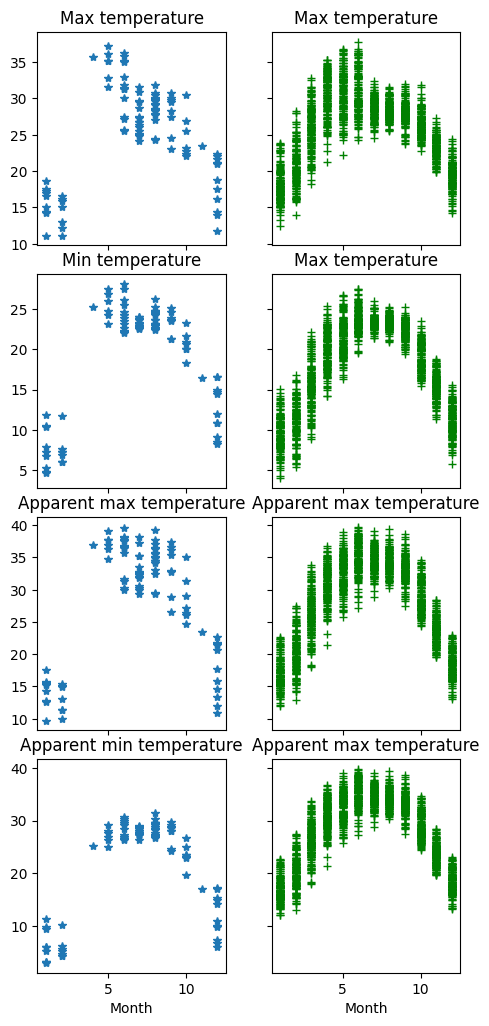

In [9]:
#Plotting and saving outlier predictions temperatures
predictions_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/predictions/"
municipal_csv = glob.glob(predictions_path+"*")
fig_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/predicted_outlier_temperature_plots/"
for filepath in municipal_csv[0:1]:
    filename = filepath.split('/')
    temp = filename[-1].replace('_', '.')
    mun_name = temp.split('.')
    mun1_df = pd.read_csv(filepath)
    print(mun_name[0])

    index = mun1_df['model_predictions'] == -1
    inlier_index = mun1_df['model_predictions'] == 1
    print("# of outliers:", index.values.sum()/len(index))
    # Count number of hot, very hot, and extreme hot days in outliers
    predicted_heat_labels = mun1_df.Heat_Label[index].value_counts()
    total_heat_labels = mun1_df.Heat_Label.value_counts()
    print ("# of outlier vs total:")
    display(predicted_heat_labels)
    display(total_heat_labels)


    fig, axes = plt.subplots(nrows=4, ncols=2, sharex='col', sharey='row', figsize=(5, 10))
    fig.tight_layout()
    plt.subplot(4, 2, 1)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][index], mun1_df['temperature_2m_max (°C)'][index], '*')
    plt.title("Max temperature") 
    
    plt.subplot(4, 2, 2)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][inlier_index], mun1_df['temperature_2m_max (°C)'][inlier_index], 'g+')
    plt.title("Max temperature") 

    plt.subplot(4, 2, 3)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][index], mun1_df['temperature_2m_min (°C)'][index], '*')
    plt.title("Min temperature")

    plt.subplot(4, 2, 4)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][inlier_index], mun1_df['temperature_2m_min (°C)'][inlier_index], 'g+')
    plt.title("Max temperature") 

    plt.subplot(4, 2, 5)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][index], mun1_df['apparent_temperature_max (°C)'][index], '*')
    plt.title("Apparent max temperature") 
    
    plt.subplot(4, 2, 6)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][inlier_index], mun1_df['apparent_temperature_max (°C)'][inlier_index], 'g+')
    plt.title("Apparent max temperature")

    plt.subplot(4, 2, 7)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][index], mun1_df['apparent_temperature_min (°C)'][index], '*')
    plt.title("Apparent min temperature")
    plt.xlabel ('Month')
    
    plt.subplot(4, 2, 8)  # 2 rows, 2 columns, first position
    plt.plot(mun1_df['month'][inlier_index], mun1_df['apparent_temperature_max (°C)'][inlier_index], 'g+')
    plt.title("Apparent max temperature")
    plt.xlabel ('Month')
    
    plt.show()
#     plt.savefig(fig_path+mun_name[0]+".png",bbox_inches='tight')
#     plt.close()

In [12]:
# Evaluations:

# Percentage of N,H,EH, VH days predicted
predictions_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/predictions/"
municipal_csv = glob.glob(predictions_path+"*")

for filepath in municipal_csv[0:10]:
    filename = filepath.split('/')
    temp = filename[-1].replace('_', '.')
    mun_name = temp.split('.')
    mun1_df = pd.read_csv(filepath)
    print(mun_name[0])

    index = mun1_df['model_predictions'] == -1
    print("% of predicted outliers:", index.values.sum()/len(index))
    dhm_pred = evaluate_dhm_pred(mun1_df, index)
    heat_labels = dhm_pred[2]
    print("# of labeled normal, hot, very hot, and extremely hot days:\n", heat_labels )
    print("# of normal, hot, very hot, and extremely hot days in outlier:\n", dhm_pred[0] )
    season_pred = evaluate_summer_winter(mun1_df, index)
    print("# of normal, hot, very hot, and extremely hot days in summer:\n", season_pred[0] )
    print("# of normal, hot, very hot, and extremely hot days in winter: \n", season_pred[1] )
   
    p90 = mun1_df['p90'][0]
    p95 = mun1_df['p95'][0]
    p99 = mun1_df['p99'][0]
    print("# of outlier days labeled normal with apparent temp:", evaluate_app_temp(mun1_df, index,p90, p95, p99))        
    

    
    

Birendranagar
% of predicted outliers: 0.05312157721796276
# of labeled normal, hot, very hot, and extremely hot days:
 (np.int64(1757), np.int64(45), np.int64(23), np.int64(1))
# of normal, hot, very hot, and extremely hot days in outlier:
 (np.int64(88), 0, np.int64(4), 0)
# of normal, hot, very hot, and extremely hot days in summer:
 (np.int64(53), np.int64(5), np.int64(4), np.int64(0))
# of normal, hot, very hot, and extremely hot days in winter: 
 (np.int64(35), np.int64(0), np.int64(0), np.int64(0))
# of outlier days labeled normal with apparent temp: (np.int64(29), np.int64(16), np.int64(3))
Chaukune
% of predicted outliers: 0.054764512595837894
# of labeled normal, hot, very hot, and extremely hot days:
 (np.int64(1755), np.int64(44), np.int64(24), np.int64(3))
# of normal, hot, very hot, and extremely hot days in outlier:
 (np.int64(98), 0, 0, 0)
# of normal, hot, very hot, and extremely hot days in summer:
 (np.int64(62), np.int64(2), np.int64(0), np.int64(0))
# of normal, ho

In [11]:
def evaluate_dhm_pred(mun1_df, index):
    # Count number of hot, very hot, and extreme hot days in outliers
    predicted_heat_labels = mun1_df.Heat_Label[index].value_counts()
    total_heat_labels = mun1_df.Heat_Label.value_counts()
    normal_pred_pc = 0; h_pred_pc = 0; vh_pred_pc = 0; eh_pred_pc = 0
    normal_pred_count = 0; h_pred_count = 0; vh_pred_count = 0; eh_pred_count = 0
    labeled_normal_c=0; labeled_hot_c=0; labeled_vh_c=0; labeled_eh_c=0
    if 'N' in total_heat_labels:
        labeled_normal_c = total_heat_labels.N
        if 'N' in predicted_heat_labels:
            normal_pred_pc = predicted_heat_labels.N/total_heat_labels.N
            normal_pred_count = predicted_heat_labels.N
        
    if 'H' in total_heat_labels:
        labeled_hot_c = total_heat_labels.H
        if 'H' in predicted_heat_labels:
            hot_pred_count = predicted_heat_labels.H
            hot_pred_pc = predicted_heat_labels.H/total_heat_labels.H
        
    if 'VH' in total_heat_labels:
        labeled_vh_c = total_heat_labels.VH
        if 'VH' in predicted_heat_labels:
            vh_pred_count = predicted_heat_labels.VH
            vh_pred_pc = predicted_heat_labels.VH/total_heat_labels.VH
        
    if 'EH' in total_heat_labels:
        labeled_eh_c = total_heat_labels.EH
        if 'EH' in predicted_heat_labels:
            eh_pred_count = predicted_heat_labels.EH
            eh_pred_pc = predicted_heat_labels.EH/total_heat_labels.EH
    
    return (normal_pred_count, h_pred_count, vh_pred_count, eh_pred_count), \
           (normal_pred_pc, h_pred_pc, vh_pred_pc, eh_pred_pc), \
           (labeled_normal_c, labeled_hot_c, labeled_vh_c, labeled_eh_c) 

def evaluate_app_temp(mun1_df, index, p90, p95, p99):
    outlier_abovep90 = (mun1_df['apparent_temperature_max (°C)'][index] > p90) & (mun1_df['Heat_Label'][index]=='N')
    total_abovep90 = mun1_df['apparent_temperature_max (°C)'] > p90
    
    outlier_abovep95 = (mun1_df['apparent_temperature_max (°C)'][index] > p95) & (mun1_df['Heat_Label'][index]=='N')
    total_abovep95 = mun1_df['apparent_temperature_max (°C)'] > p95
    
    outlier_abovep99 = (mun1_df['apparent_temperature_max (°C)'][index] > p99) & (mun1_df['Heat_Label'][index]=='N')
    total_abovep99 = mun1_df['apparent_temperature_max (°C)'] > p99


    return outlier_abovep90.sum(), outlier_abovep95.sum(), outlier_abovep99.sum()
#     return (outlier_abovep90.sum(), total_abovep90.sum()), (outlier_abovep95.sum(), total_abovep95.sum()), (outlier_abovep99.sum(), total_abovep99.sum())
    
def evaluate_summer_winter(mun1_df, index):
    outlier_months = mun1_df.month[index]
    summer_outlier_n = (mun1_df['month'][index] >= 4) & (mun1_df['month'][index] <= 9) & (mun1_df['Heat_Label'][index]=='N')
    summer_outlier_h = (mun1_df['month'][index] >= 4) & (mun1_df['month'][index] <= 9) & (mun1_df['Heat_Label'][index]=='H')
    summer_outlier_vh = (mun1_df['month'][index] >= 4) & (mun1_df['month'][index] <= 9) & (mun1_df['Heat_Label'][index]=='VH')
    summer_outlier_eh = (mun1_df['month'][index] >= 4) & (mun1_df['month'][index] <= 9) & (mun1_df['Heat_Label'][index]=='EH')     
    
    winter_outlier_n = ((mun1_df['month'][index] < 4) | (mun1_df['month'][index] > 9)) & (mun1_df['Heat_Label'][index]=='N')
    winter_outlier_h = ((mun1_df['month'][index] < 4) | (mun1_df['month'][index] > 9)) & (mun1_df['Heat_Label'][index]=='H')
    winter_outlier_vh = ((mun1_df['month'][index] < 4) | (mun1_df['month'][index] > 9)) & (mun1_df['Heat_Label'][index]=='VH')
    winter_outlier_eh = ((mun1_df['month'][index] < 4) | (mun1_df['month'][index] > 9)) & (mun1_df['Heat_Label'][index]=='EH')
    
    return (summer_outlier_n.sum(), summer_outlier_h.sum(), summer_outlier_vh.sum(), summer_outlier_eh.sum()), \
            (winter_outlier_n.sum(), winter_outlier_h.sum(), winter_outlier_vh.sum(), winter_outlier_eh.sum())
    
    

In [ ]:
outlier_months = mun1_df.month[index]
summer_outlier = (mun1_df['month'][index] >= 4) & (mun1_df['month'][index] <= 9) & (mun1_df['Heat_Label'][index]=='N')
print(summer_outlier.sum())
winter_outlier = ((mun1_df['month'][index] < 4) | (mun1_df['month'][index] > 9)) & (mun1_df['Heat_Label'][index]=='N')
print(winter_outlier.sum())

lekbeshi
% of outliers: 16.142857142857142


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


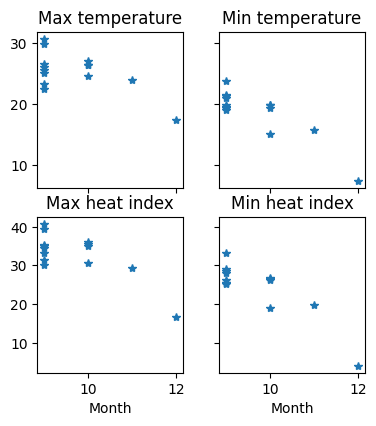

Badhaiyatal
% of outliers: 20.11764705882353


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


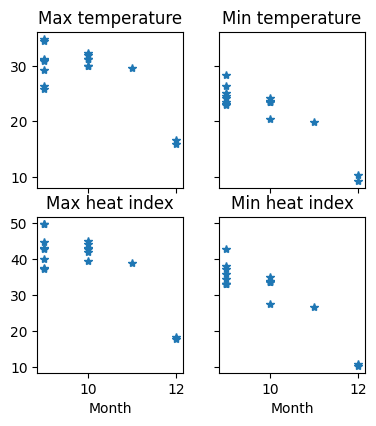

Nepalgunj
% of outliers: 16.61111111111111


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


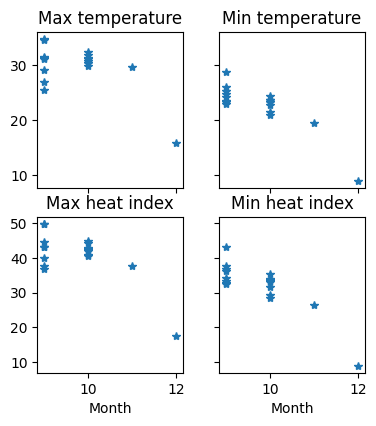

Bardiya National Park
% of outliers: 13.38888888888889


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


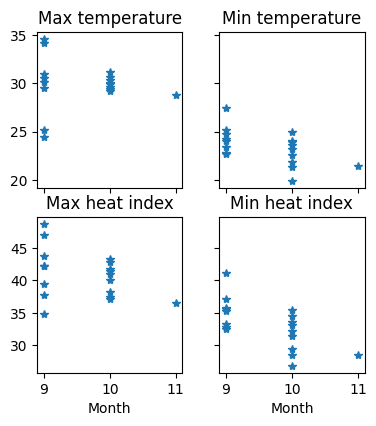

Birendranagar
% of outliers: 21.55


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


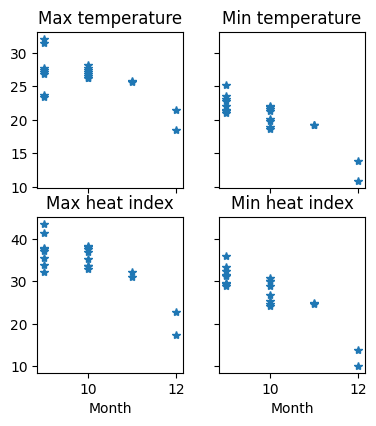

Chingad
% of outliers: 21.27777777777778


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


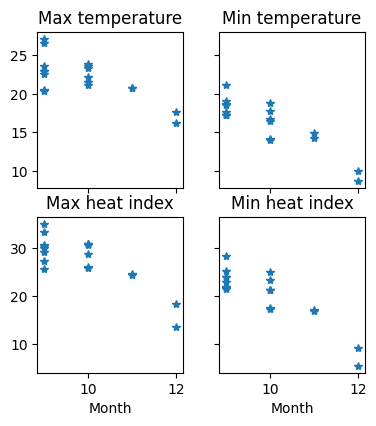

Gulariya
% of outliers: 21.055555555555557


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


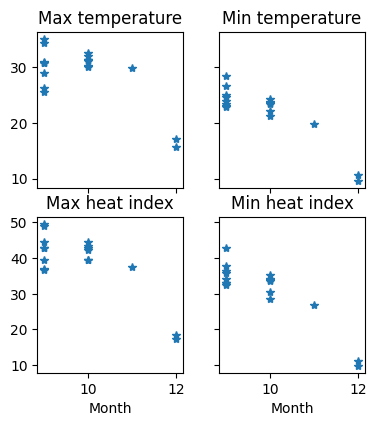

rapti
% of outliers: 18.071428571428573


/Users/shreyasha/anaconda3/envs/heat_ai/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


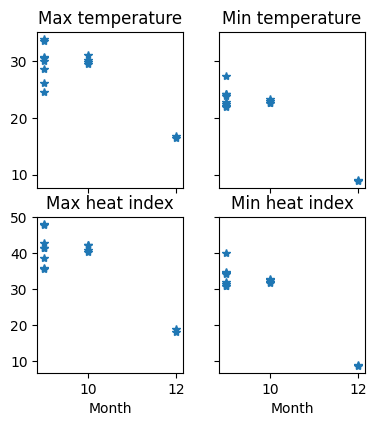

In [27]:
# testing on forecast data
forecast_data_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/municipality_forecast_csv"
municipal_csv = glob.glob(forecast_data_path+"/*")
for filepath in municipal_csv:
    filename = filepath.split('/')
    temp = filename[-1].replace('_', '.')
    mun_name = temp.split('.')
    mun1_df = pd.read_csv(filepath)
    print(mun_name[0])
    inference_array = extract_inference_data(mun1_df)

    # get yy,mm,dd for filtering
    data_dates = mun1_df['date'].apply(lambda x: extract_month(x))
    data_dates.columns = ['yy','month','dd']
    
    #Load model
    model_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/github/Heat-AI/models/"
    model_name = mun_name[0] +"_oneClassSVM_rbf_1993-2019_allmonths.pkl"
    with open(model_path+model_name,'rb') as f:
        trained_model = pickle.load(f)
    y_pred = trained_model.predict(inference_array)
    index = np.where(y_pred == -1)[0]
    print("% of outliers:", index.sum()/len(index))

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(4,4))
    fig.tight_layout()
    plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first position
    plt.plot(data_dates['month'][index], mun1_df['max_air_temperature'][index], '*')
    plt.title("Max temperature") 
    
    # plt.subplot(4, 2, 2)  # 2 rows, 2 columns, first position
    # plt.plot(data_dates['month'][inlier_index], mun1_df['max_air_temperature'][inlier_index], 'g+')
    # plt.title("Max temperature") 

    plt.subplot(2, 2, 2)  # 2 rows, 2 columns, first position
    plt.plot(data_dates['month'][index], mun1_df['min_air_temperature'][index], '*')
    plt.title("Min temperature")

    # plt.subplot(4, 2, 4)  # 2 rows, 2 columns, first position
    # plt.plot(data_dates['month'][inlier_index], mun1_df['min_air_temperature'][inlier_index], 'g+')
    # plt.title("Max temperature") 

    plt.subplot(2, 2, 3)  # 2 rows, 2 columns, first position
    plt.plot(data_dates['month'][index], mun1_df['max_calculated_heat_index'][index], '*')
    plt.title("Max heat index") 
    plt.xlabel ('Month')
    # plt.subplot(4, 2, 6)  # 2 rows, 2 columns, first position
    # plt.plot(data_dates['month'][inlier_index], mun1_df['max_calculated_heat_index'][inlier_index], 'g+')
    # plt.title("Apparent max temperature")

    plt.subplot(2, 2, 4)  # 2 rows, 2 columns, first position
    plt.plot(data_dates['month'][index], mun1_df['min_calculated_heat_index'][index], '*')
    plt.title("Min heat index")
    plt.xlabel ('Month')
    
    # plt.subplot(4, 2, 8)  # 2 rows, 2 columns, first position
    # plt.plot(data_dates['month'][inlier_index], mun1_df['min_calculated_heat_index'][inlier_index], 'g+')
    # plt.title("Apparent max temperature")
    # plt.xlabel ('Month')
    
    plt.show()


In [14]:
def extract_inference_data(forecast_dict):
  inference_array = np.zeros((len(forecast_dict),9)) # number of days, number of features
  for x in range(len(forecast_dict)):
    for key in forecast_dict.columns:
      if key == "max_air_temperature":
        inference_array[x,0] = forecast_dict[key][x]
      if key == "min_air_temperature":
        inference_array[x,1] = forecast_dict[key][x]
      if key == "mean_air_temperature":
        inference_array[x,2] = forecast_dict[key][x]
      if key == "max_calculated_heat_index": #apparent temperature
        inference_array[x,3] = forecast_dict[key][x]
      if key == "min_calculated_heat_index": #apparent temperature
        inference_array[x,4] = forecast_dict[key][x]
      if key == "mean_calculated_heat_index": #apparent temperature
        inference_array[x,5] = forecast_dict[key][x]
      if key == "total precipitation": #
        inference_array[x,6] = forecast_dict[key][x]
      if key == "date":
        forecast_date = extract_month(forecast_dict[key][x])
        inference_array[x,7] = forecast_date[1]
        inference_array[x,8] = forecast_date[2]
  return inference_array


In [17]:
mun1_df

,date,min_air_pressure_at_sea_level,max_air_pressure_at_sea_level,min_air_temperature,max_air_temperature,min_cloud_area_fraction,max_cloud_area_fraction,min_relative_humidity,max_relative_humidity,min_wind_speed,max_wind_speed,min_calculated_heat_index,max_calculated_heat_index,min_calculated_wet_bulb_temperature,max_calculated_wet_bulb_temperature,mean_calculated_heat_index,mean_air_temperature,total_precipitation
0,2024-09-23,1003.9,1008.2,23.8,30.6,14.1,67.2,61.0,93.0,0.9,2.2,33.1,40.7,22.4,25.1,37.441667,27.416667,0.5
1,2024-09-24,1004.1,1010.2,21.5,29.8,0.0,100.0,60.6,94.5,1.1,2.4,29.0,39.3,20.3,24.7,33.700000,24.933333,3.3
2,2024-09-25,1006.0,1010.7,21.0,26.0,78.1,100.0,73.2,96.2,0.8,2.5,28.1,35.1,19.8,23.1,31.216667,23.050000,3.5
3,2024-09-26,1004.7,1009.4,21.3,25.6,30.5,100.0,78.2,95.4,0.7,1.9,28.5,34.5,20.0,22.8,31.433333,23.166667,9.6
4,2024-09-27,1004.9,1009.1,19.5,22.5,100.0,100.0,88.6,96.9,0.8,2.8,25.5,31.3,18.4,21.7,29.241667,21.416667,111.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2024-12-27,1018.5,1022.1,8.0,19.4,11.7,100.0,33.5,67.2,0.6,2.2,6.2,17.9,4.7,11.1,11.270833,12.791667,0.0
91,2024-12-28,1016.3,1020.9,10.3,18.3,30.5,100.0,47.1,96.7,0.7,3.3,10.3,18.3,7.1,12.4,13.291667,13.095833,8.5
92,2024-12-29,1018.0,1019.7,7.9,17.0,0.8,100.0,58.1,95.4,0.6,2.5,6.8,16.7,6.1,11.7,10.877778,10.811111,0.0
93,2024-12-30,1017.1,1018.8,8.5,17.4,0.0,43.0,47.5,94.8,0.1,1.5,6.1,16.3,4.3,10.7,10.300000,11.725000,0.0
